In [1]:
from glob import glob
import cv2
import numpy as np
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
%matplotlib inline

# Calibrate camera

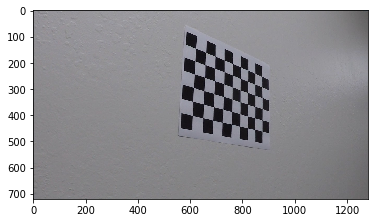

In [2]:
cali_dir = "C:\\Users\\DavidCrompton\\Documents\\git\\artificial_intelligence\\CarND-Advanced-Lane-Lines\\camera_cal\\"
img_cal = glob(cali_dir + "*.jpg")

# Plot last image
img = mpimage.imread(img_cal[-1])
plt.imshow(img)


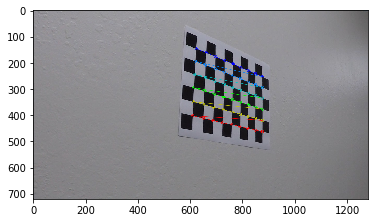

In [3]:
obj_points = []
img_points = []

objp = np.zeros((6*9,3), np.float32)[:,]
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

for img in img_cal:
    
    img = mpimage.imread(img)

    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # If found, draw corners
    if ret == True:
        obj_points.append(objp)
        img_points.append(corners)
    
    # Draw and display the corners of the last image
    cv2.drawChessboardCorners(img, (9, 6), corners, ret)
    plt.imshow(img)
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points, img_points, gray.shape[::-1], None, None)

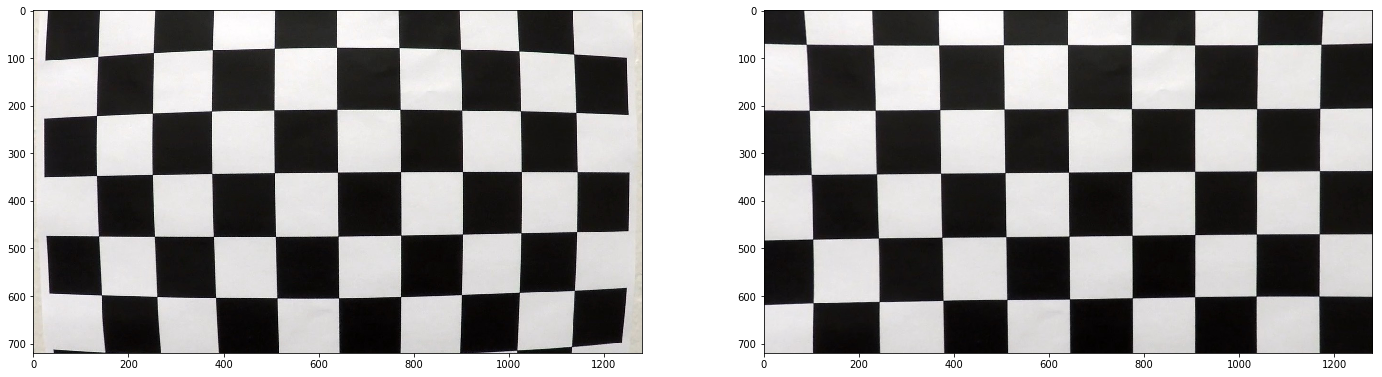

In [4]:
img = mpimage.imread(img_cal[0])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
dst = cv2.undistort(img, mtx, dist, None, mtx)
ax2.imshow(dst)

## Distortion correction

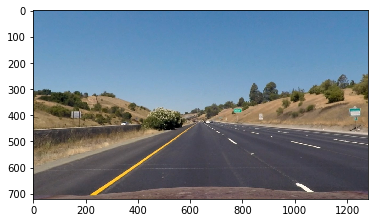

In [5]:
test_dir = "C:\\Users\\DavidCrompton\\Documents\\git\\artificial_intelligence\\CarND-Advanced-Lane-Lines\\test_images\\"
img_test = glob(test_dir + "*.jpg")

# Plot first image
img = mpimage.imread(img_test[0])
img = cv2.undistort(img, mtx, dist, None, mtx)
plt.imshow(img)


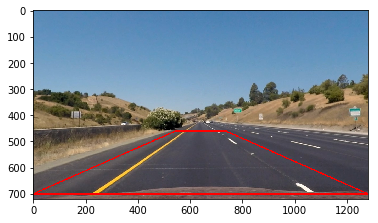

In [6]:
left_top = (545, 460)
left_bottom = (0, 700)
right_top = (735, 460) 
right_bottom = (1280, 700)



cv2.line(img, left_bottom, left_top, color=[255, 0, 0], thickness=4)
cv2.line(img, right_bottom, right_top, color=[255, 0, 0], thickness=4)
cv2.line(img, left_top, right_top, color=[255, 0, 0], thickness=4)
cv2.line(img, left_bottom, right_bottom, color=[255, 0, 0], thickness=4)
plt.imshow(img)

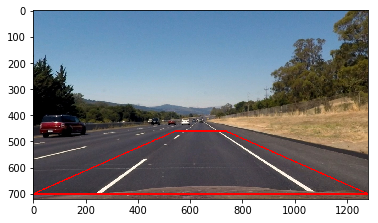

In [7]:
img = mpimage.imread(img_test[1])
img = cv2.undistort(img, mtx, dist, None, mtx)
cv2.line(img, left_bottom, left_top, color=[255, 0, 0], thickness=4)
cv2.line(img, right_bottom, right_top, color=[255, 0, 0], thickness=4)
cv2.line(img, left_top, right_top, color=[255, 0, 0], thickness=4)
cv2.line(img, left_bottom, right_bottom, color=[255, 0, 0], thickness=4)
plt.imshow(img)

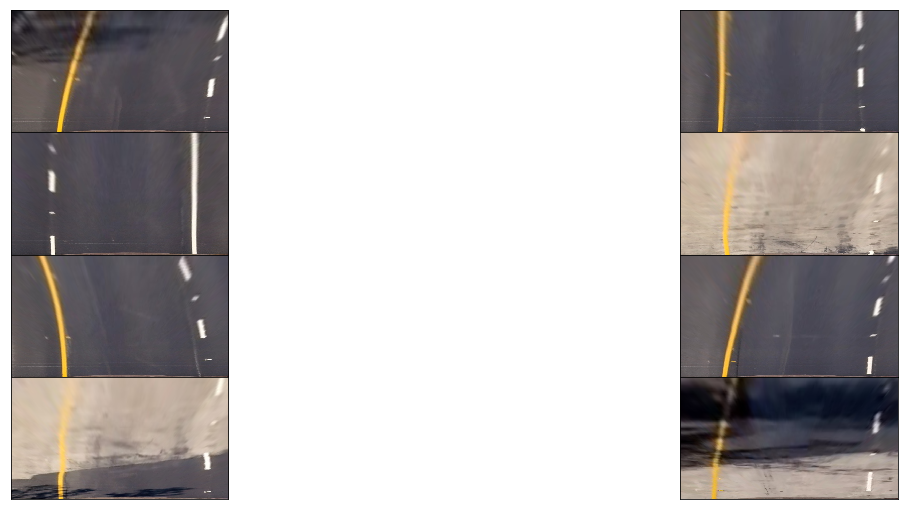

In [8]:
src = np.float32([[545, 460],[735, 460],[1280, 700],[0, 700]])

dst = np.float32([[0, 0], [1280, 0],[1280, 720],[0, 720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
img_size = (img.shape[1], img.shape[0])    

idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
switch = 0
for ii, ax in zip(idx, axes.flatten()):
    img = mpimage.imread(img_test[ii-1])
    img = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(img, M, img_size)
    ax.imshow(warped, aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)


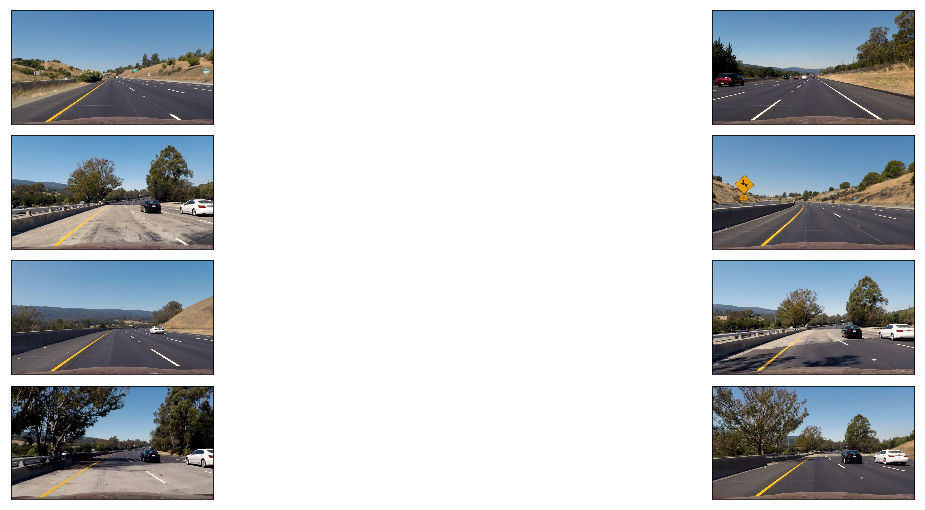

In [9]:
test_imgs = []
for img in img_test:
    img = mpimage.imread(img)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    test_imgs.append(img)

idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(test_imgs[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Define thresholds

In [10]:
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=255):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output
    
def gradient_mag(img, sobel_kernel=9, mag_thresh=(30, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=9, thresh=(0.7, 1.3)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask

def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask

def colour_threshold(img, thresh=(130,255)):
    img = np.copy(img)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    binary_output =  np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

"""
def region_of_interest(img):
    left_bottom = [60, 540]
    right_bottom = [940, 540]
    apex = [480, 270]
    vertices = [np.array([left_bottom, right_bottom, apex])]
    
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    mask = np.zeros_like(gray)   
    ignore_mask_color = 1
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
    """

'\ndef region_of_interest(img):\n    left_bottom = [60, 540]\n    right_bottom = [940, 540]\n    apex = [480, 270]\n    vertices = [np.array([left_bottom, right_bottom, apex])]\n    \n    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)\n    mask = np.zeros_like(gray)   \n    ignore_mask_color = 1\n    #filling pixels inside the polygon defined by "vertices" with the fill color    \n    cv2.fillPoly(mask, vertices, ignore_mask_color)\n    masked_image = cv2.bitwise_and(img, mask)\n    return masked_image\n    '

## Yellow white thresholds

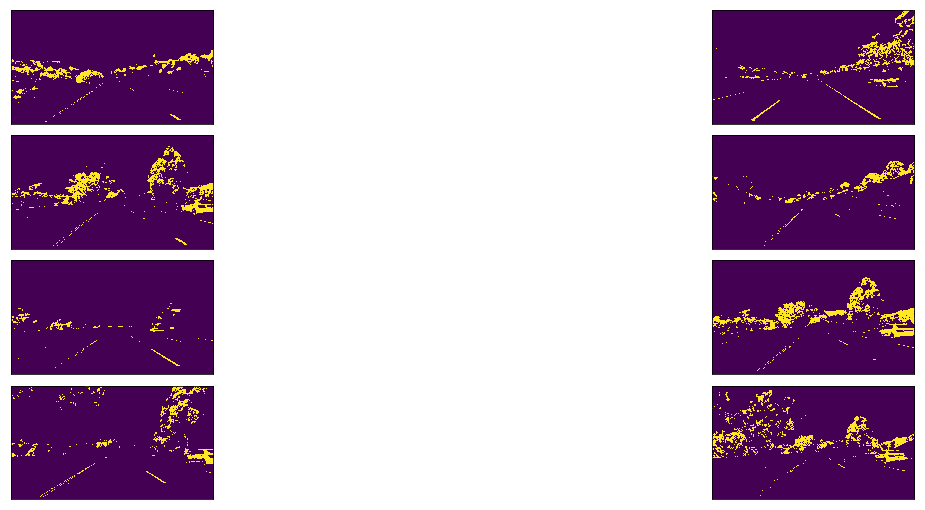

In [11]:
thresholds = []
for img in test_imgs:
    white = select_white(img)
    yellow = select_yellow(img)
    combined = np.zeros_like(yellow).astype(np.uint8)
    combined[(yellow >= 1) | (white >= 1)] = 1
    thresholds.append(combined)
    
idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(thresholds[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Playing with sobel thresholds

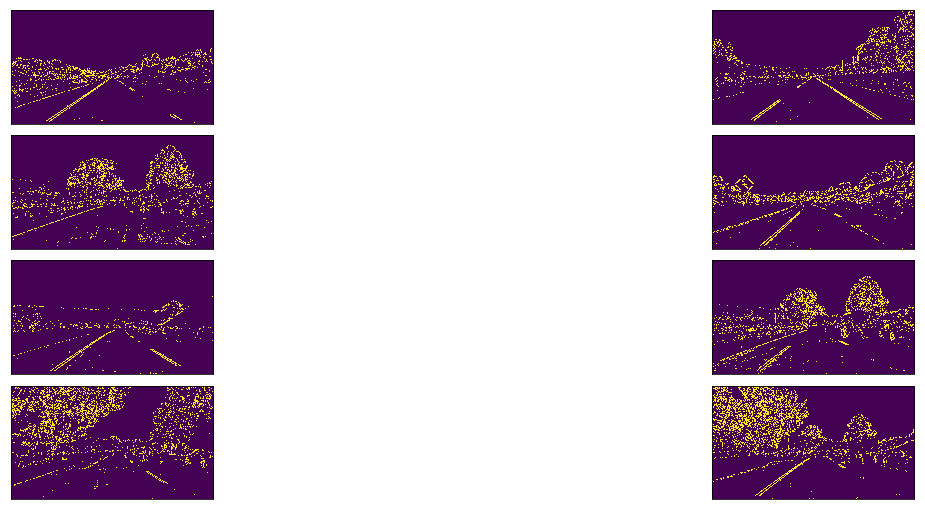

In [12]:
thresholds = []
for img in test_imgs:
    absx_img = abs_sobel_thresh(img, "x")
    absy_img = abs_sobel_thresh(img, "y")
    grad_img = gradient_mag(img)
    dir_img = dir_threshold(img)
    combined = np.zeros_like(dir_img)
    combined[((absx_img == 1) & (absy_img == 0)) | ((grad_img == 1) & (dir_img == 1))] = 1
    thresholds.append(combined)
    
idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(thresholds[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Playing with color thresholds

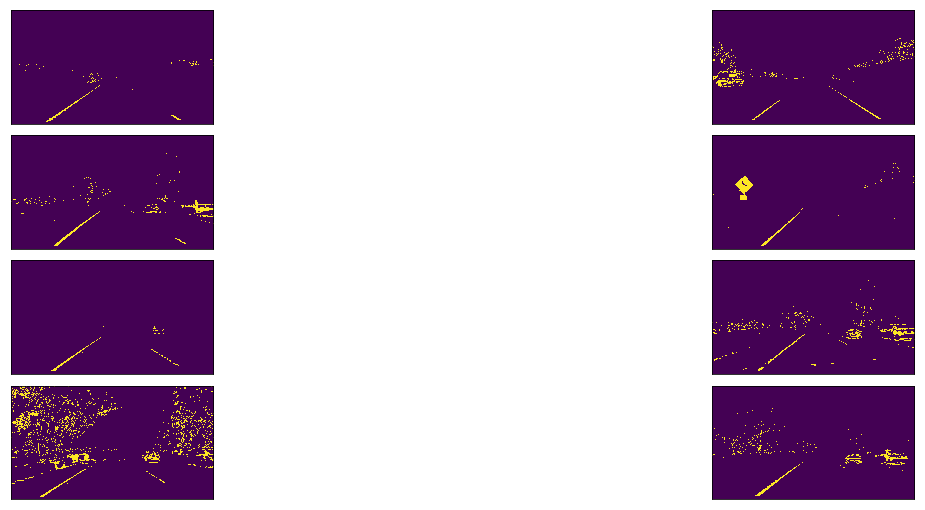

In [13]:
thresholds = []
for img in test_imgs:
    colour_img = colour_threshold(img, (170,255))
    thresholds.append(colour_img)
    
idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(thresholds[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Combining thresholds

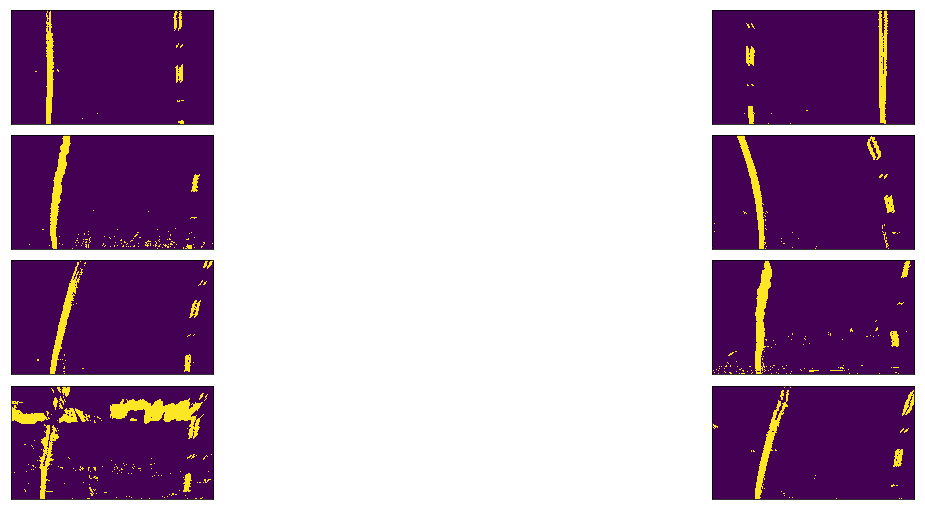

In [14]:
warped_imgs = []
for img in img_test:
    img = mpimage.imread(img)
    img = cv2.undistort(img, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(img, M, img_size)
    warped_imgs.append(warped)

thresholds = []
for img in warped_imgs:
    absx_img = abs_sobel_thresh(img, "x")
    absy_img = abs_sobel_thresh(img, "y")
    grad_img = gradient_mag(img, mag_thresh=(30,255))
    dir_img = dir_threshold(img, thresh=(0.7, 1.3))
    colour_img = colour_threshold(img, (130,255))
    white = select_white(img)
    yellow = select_yellow(img)
    combined = np.zeros_like(yellow).astype(np.uint8)
    combined = np.zeros_like(dir_img)
    combined[
        ((colour_img == 1)) 
        | ((absx_img == 1)) 
        | ((white == 1)) 
        | ((yellow == 1)) 
        #| ((grad_img == 1) & (dir_img == 1))
    ] = 1
    thresholds.append(combined)
    
idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(thresholds[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Threshold pipeline

In [15]:
def combine(img1, img2):
    combined = np.zeros_like(img1)
    combined[((img1 == 1) & (img2 == 1))] = 1
    return combined
    

def pipeline(img):
    white = select_white(img)
    yellow = select_yellow(img)
    combined = np.zeros_like(yellow).astype(np.uint8)
    combined[ ((yellow >= 1)) | ((white >= 1))] = 1
    return combined

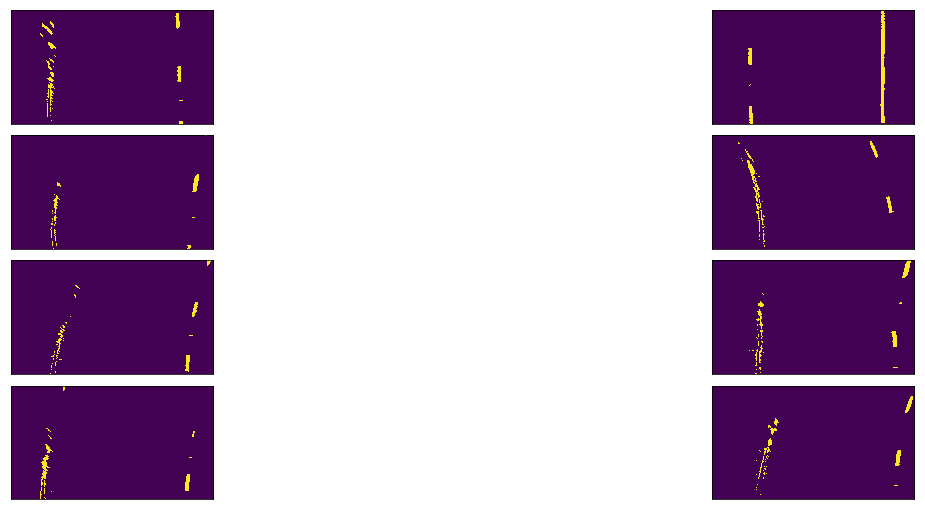

In [16]:
thresholds = []
for img in warped_imgs:
    img = pipeline(img)
    thresholds.append(img)
    
idx = range(len(img_test))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(thresholds[ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Finding lanes from threshold features

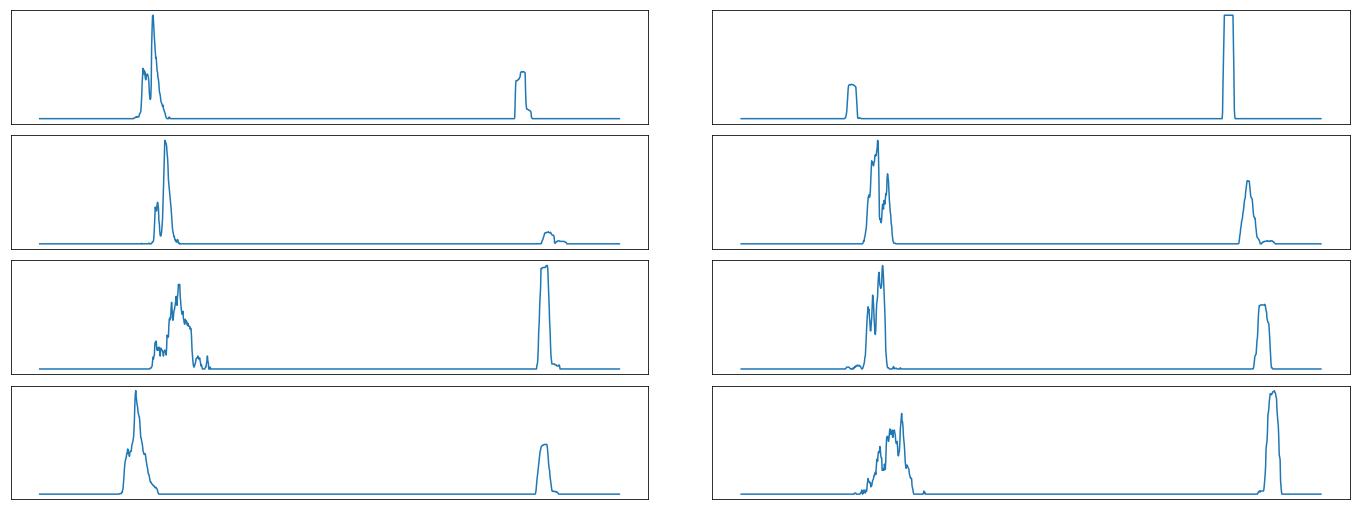

In [17]:
histograms = []
for img in thresholds:
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    histograms.append(histogram)
    
idx = range(len(thresholds))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.plot(histograms[ii])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Extract peak values for left and right lane
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint


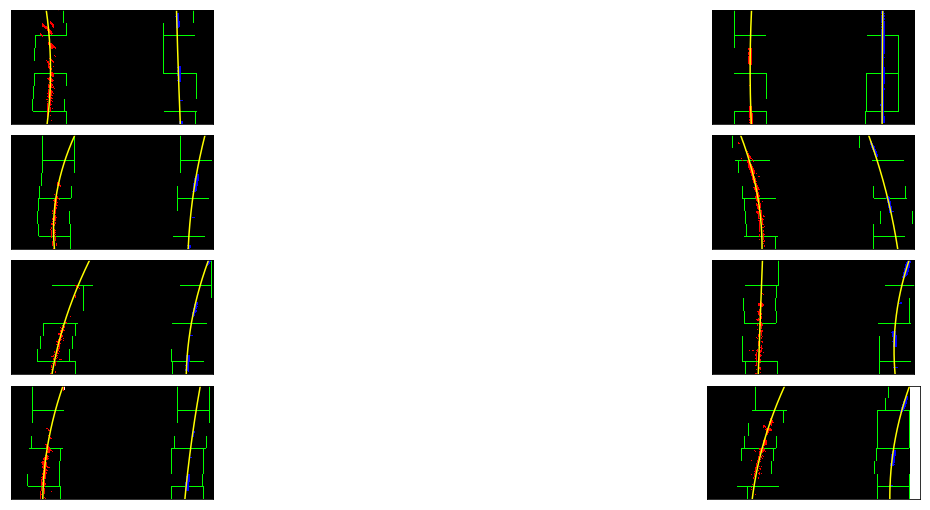

In [18]:
nwindows = 9

plot_images = []
plot_lines = []

for img in thresholds:
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    out_img = np.dstack((img, img, img))*255
    out_img = np.ndarray.astype(out_img, np.uint8)
    # Extract peak values for left and right lane
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plot_images.append(out_img)
    plot_lines.append([left_fitx, right_fitx])
    
idx = range(len(plot_images))
fig, axes = plt.subplots(4, 2, figsize=(24,9),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(plot_images[ii])
    ax.plot(plot_lines[ii][0], ploty, color='yellow')
    ax.plot(plot_lines[ii][1], ploty, color='yellow')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)

## Define a lane class to keep track of things

In [19]:
class Line():
    def __init__(self, Minv):
        # was the line detected in the last iteration?
        self.detected = False
        self.left_fits = []
        self.right_fits = []
        self.Minv = Minv
        self.curves = [(0,0)]
        self.frame = 0
        
    def curve(self, img, leftx,rightx, lefty, righty):
        """
        Calculates the curve of both the left lane and the right lane in meters
        """
        ploty = np.linspace(0, 719, num=720)
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        return (left_curverad, right_curverad)
        
    def draw(self, img, undist):
        left_fit, right_fit = self.find_poly(img)
        warp_zero = np.zeros_like(img).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero)).astype(np.uint8)
        
        ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        
        cv2.putText(result, "The left and right curves are approx {} and {} meters".format(self.curves[-1][0], self.curves[-1][1]), (40, 100),
            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 1)
        
        return result
    
    def weighted_average(self):
        avg_left = np.asarray(self.left_fits)
        avg_right = np.asarray(self.right_fits)
        avg_left = np.average(avg_left, axis=0, weights=np.exp(range(0,len(avg_left))))
        avg_right = np.average(avg_right, axis=0, weights=np.exp(range(0,len(avg_right))))
        return avg_left, avg_right
        
    def find_poly(self, img):
        if self.detected == False:
            left_fit, right_fit = self.poly_fit(img)
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
            self.detected == True
            return left_fit, right_fit
        else:
            left_fit, right_fit = self.poly_update(img, self.left_fits[-1], self.right_fits[-1])
            self.left_fits.append(left_fit)
            self.right_fits.append(right_fit)
            return self.weighted_average()
    
    def histogram(self, img):
        return np.sum(img[img.shape[0]//2:,:], axis=0)
    
    def poly_update(self, img, left_fit, right_fit):
        """
        If we already fitted a previous image, we can use those fits to speed up finding the fit on this image.
        Args:
            Image, left_fit, right_fit
        Returns:
            polynomial fit for left and right lane
            left_fit, right_fit
        """
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        if self.frame % 60 == 0:
            self.curves.append(self.curve(img,leftx,rightx, lefty, righty))
        self.frame = self.frame + 1
   
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        if any(left_fit == 0) or any(right_fit == 0):
            left_fit, right_fit = self.poly_fit(img)
        
        return left_fit, right_fit
        
    def poly_fit(self, img):
        """
        Takes an image of lanes and returns a polynomial fit of the two lane lines.
        Used when we are finding the fit for the first time.
        Args:
            Image
        Returns:
            polynomial fit for left and right lane
            left_fit, right_fit
        """
        nwindows = 9
        
        histogram = self.histogram(img)
        
        # Extract peak values for left and right lane
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Set height of windows
        window_height = np.int(img.shape[0]/nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 100
        
        # Set minimum number of pixels found to recenter window
        minpix = 50
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = img.shape[0] - (window+1)*window_height
            win_y_high = img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        if self.frame % 60 == 0:
            self.curves.append(self.curve(img,leftx,rightx, lefty, righty))
        self.frame = self.frame + 1
        
        return left_fit, right_fit
        

## Make video

In [20]:
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
lines = Line(Minv)

def process_image(image):
    img = cv2.undistort(image, mtx, dist, None, mtx)
    warped = cv2.warpPerspective(img, M, img_size)
    features = pipeline(warped)
    image = lines.draw(features, img)
    return image

In [22]:
white_output = "test.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test.mp4
[MoviePy] Writing video test.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [01:40<00:00, 13.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test.mp4 

Wall time: 1min 40s
